<a href="https://colab.research.google.com/github/A8Y/StudyAI/blob/master/Day2_Programming_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Day2 演習

考察とまとめ：

演習1：

XavierとReLuを組み合わせたところSigmoidより精度が上がった

HeとSigmoidにすると学習の精度が大幅に落ちた。



演習2:



演習3：





In [ ]:
import sys
sys.path.append('/content/drive/My Drive/Pythonライブラリ基礎講座/DNN_code_colab_ver200425')

In [ ]:
import numpy as np
from data.mnist import load_mnist
from PIL import Image
import pickle
from common import functions
import matplotlib.pyplot as plt
%matplotlib inline

# mnistをロード
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)
train_size = len(x_train)


# 重みを初期化



## [try1] 活性化関数や重みの初期値を変えてみよう

## Xavier

*   活性化関数をReLUに変更
*   中間層ノード数をそれぞれ100と30に変更

結果：

Sigmoid活性化関数より精度が上がった

各隠れ層のノードを二倍にしたが精度にほとんど変化なし

In [ ]:
# Xavier-ReLu  784-100-30-10

#入力層サイズ
input_layer_size = 784
#中間層サイズ
hidden_layer_1_size = 50
hidden_layer_2_size = 20
#出力層サイズ
output_layer_size = 10
# 繰り返し数
iters_num = 2000
# ミニバッチサイズ
batch_size = 100
# 学習率
learning_rate = 0.1
# 描写頻度
plot_interval=10

# 初期設定
def init_network():
    network = {} 
    
    ###########  変更箇所  ##############
    
    # Xavierの初期値
    network['W1'] = np.random.randn(input_layer_size, hidden_layer_1_size) / (np.sqrt(input_layer_size))
    network['W2'] = np.random.randn(hidden_layer_1_size, hidden_layer_2_size) / (np.sqrt(hidden_layer_1_size))
    network['W3'] = np.random.randn(hidden_layer_2_size, output_layer_size) / (np.sqrt(hidden_layer_2_size))
    
    #################################
    
    network['b1'] = np.zeros(hidden_layer_1_size)
    network['b2'] = np.zeros(hidden_layer_2_size)
    network['b3'] = np.zeros(output_layer_size)

    return network

# 順伝播
def forward(network, x):
    W1, W2, W3 = network['W1'], network['W2'], network['W3']
    b1, b2, b3 = network['b1'], network['b2'], network['b3']
#    hidden_f = functions.sigmoid
    hidden_f = functions.relu
    
    u1 =  np.dot(x, W1) + b1
    z1 = hidden_f(u1)
    u2 =  np.dot(z1, W2) + b2
    z2 = hidden_f(u2)
    u3 =  np.dot(z2, W3) + b3
    y = functions.softmax(u3)
 
    return z1, z2, y

# 誤差逆伝播
def backward(x, d, z1, z2, y):
    grad = {}
    
    W1, W2, W3 = network['W1'], network['W2'], network['W3']
    b1, b2, b3 = network['b1'], network['b2'], network['b3']
    hidden_d_f = functions.d_relu
    #hidden_d_f = functions.d_sigmoid
    
    # 出力層でのデルタ
    delta3 = functions.d_softmax_with_loss(d, y)
    # b3の勾配
    grad['b3'] = np.sum(delta3, axis=0)
    # W3の勾配
    grad['W3'] = np.dot(z2.T, delta3)
    # 2層でのデルタ
    delta2 = np.dot(delta3, W3.T) * hidden_d_f(z2)
    # b2の勾配
    grad['b2'] = np.sum(delta2, axis=0)
    # W2の勾配
    grad['W2'] = np.dot(z1.T, delta2)
    # 1層でのデルタ
    delta1 = np.dot(delta2, W2.T) * hidden_d_f(z1)
    # b1の勾配
    grad['b1'] = np.sum(delta1, axis=0)
    # W1の勾配
    grad['W1'] = np.dot(x.T, delta1)

    return grad

# パラメータの初期化
network = init_network()

accuracies_train = []
accuracies_test = []

# 正答率
def accuracy(x, d):
    z1, z2, y = forward(network, x)
    y = np.argmax(y, axis=1)
    if d.ndim != 1 : d = np.argmax(d, axis=1)
    accuracy = np.sum(y == d) / float(x.shape[0])
    return accuracy

for i in range(iters_num):
    # ランダムにバッチを取得    
    batch_mask = np.random.choice(train_size, batch_size)
    # ミニバッチに対応する教師訓練画像データを取得    
    x_batch = x_train[batch_mask]
    # ミニバッチに対応する訓練正解ラベルデータを取得する
    d_batch = d_train[batch_mask]


    
    z1, z2, y = forward(network, x_batch)
    grad = backward(x_batch, d_batch, z1, z2, y)

    if (i+1)%plot_interval==0:
        accr_test = accuracy(x_test, d_test)
        accuracies_test.append(accr_test)
        
        accr_train = accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)

#        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
 #       print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))
        
    # パラメータに勾配適用
    for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
        network[key]  -= learning_rate * grad[key]


lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

KeyboardInterrupt: ignored

## He

Sigmoidに変えてみる

結果：

HeはReLu関数に特化した重みの最適法なので予想道り精度は悪化

In [ ]:
# He-Sigmoid 784-100-30-10

# 重み初期値補正係数
wieght_init = 0.01
#入力層サイズ
input_layer_size = 784
#中間層サイズ
hidden_layer_1_size = 100
hidden_layer_2_size = 30

#出力層サイズ
output_layer_size = 10
# 繰り返し数
iters_num = 2000
# ミニバッチサイズ
batch_size = 100
# 学習率
learning_rate = 0.1
# 描写頻度
plot_interval=10

# 初期設定
def init_network():
    network = {} 

    ###########  変更箇所  ##############

    # Heの初期値
    network['W1'] = np.random.randn(input_layer_size, hidden_layer_1_size) / np.sqrt(input_layer_size) * np.sqrt(2)
    network['W2'] = np.random.randn(hidden_layer_1_size, hidden_layer_2_size) / np.sqrt(hidden_layer_1_size) * np.sqrt(2)
    network['W3'] = np.random.randn(hidden_layer_2_size, output_layer_size) / np.sqrt(hidden_layer_2_size) * np.sqrt(2)
        
    #################################
    
    network['b1'] = np.zeros(hidden_layer_1_size)
    network['b2'] = np.zeros(hidden_layer_2_size)
    network['b3'] = np.zeros(output_layer_size)

    return network

# 順伝播
def forward(network, x):
    W1, W2, W3 = network['W1'], network['W2'], network['W3']
    b1, b2, b3 = network['b1'], network['b2'], network['b3']

    ###########  変更箇所  ##############
    
 #   hidden_f = functions.relu
    hidden_f = functions.sigmoid
    
    #################################
    
    u1 =  np.dot(x, W1) + b1
    z1 = hidden_f(u1)
    u2 =  np.dot(z1, W2) + b2
    z2 = hidden_f(u2)
    u3 =  np.dot(z2, W3) + b3
    y = functions.softmax(u3)
 
    return z1, z2, y

# 誤差逆伝播
def backward(x, d, z1, z2, y):
    grad = {}
    
    W1, W2, W3 = network['W1'], network['W2'], network['W3']
    b1, b2, b3 = network['b1'], network['b2'], network['b3']
    
    ###########  変更箇所  ##############
    
    hidden_d_f = functions.d_sigmoid
   # hidden_d_f = functions.d_relu

    #################################
    
    # 出力層でのデルタ
    delta3 = functions.d_softmax_with_loss(d, y)
    # b3の勾配
    grad['b3'] = np.sum(delta3, axis=0)
    # W3の勾配
    grad['W3'] = np.dot(z2.T, delta3)
    # 2層でのデルタ
    delta2 = np.dot(delta3, W3.T) * hidden_d_f(z2)
    # b2の勾配
    grad['b2'] = np.sum(delta2, axis=0)
    # W2の勾配
    grad['W2'] = np.dot(z1.T, delta2)
    # 1層でのデルタ
    delta1 = np.dot(delta2, W2.T) * hidden_d_f(z1)
    # b1の勾配
    grad['b1'] = np.sum(delta1, axis=0)
    # W1の勾配
    grad['W1'] = np.dot(x.T, delta1)

    return grad

# パラメータの初期化
network = init_network()

accuracies_train = []
accuracies_test = []

# 正答率
def accuracy(x, d):
    z1, z2, y = forward(network, x)
    y = np.argmax(y, axis=1)
    if d.ndim != 1 : d = np.argmax(d, axis=1)
    accuracy = np.sum(y == d) / float(x.shape[0])
    return accuracy

for i in range(iters_num):
    # ランダムにバッチを取得    
    batch_mask = np.random.choice(train_size, batch_size)
    # ミニバッチに対応する教師訓練画像データを取得    
    x_batch = x_train[batch_mask]
    # ミニバッチに対応する訓練正解ラベルデータを取得する
    d_batch = d_train[batch_mask]


    
    z1, z2, y = forward(network, x_batch)
    grad = backward(x_batch, d_batch, z1, z2, y)

    if (i+1)%plot_interval==0:
        accr_test = accuracy(x_test, d_test)
        accuracies_test.append(accr_test)
        
        accr_train = accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)

#        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
#        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))
        
    # パラメータに勾配適用
    for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
        network[key]  -= learning_rate * grad[key]


lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

# 学習率最適化手法

## [try2 ] 

活性化関数と重みの初期化方法を変更して違いを見てみよう


MomentumをもとにAdaGradを作ってみよう
θ = 1e-4 とする



In [ ]:
sys.path.append('/content/drive/My Drive/Pythonライブラリ基礎講座/DNN_code_colab_ver200425/lesson_2')
from multi_layer_net import MultiLayerNet

In [ ]:
# AdaGradを作ってみよう
# データの読み込み
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)

print("データ読み込み完了")

# batch_normalizationの設定 ================================
use_batchnorm = True
#use_batchnorm = False
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[40, 20], output_size=10, activation='sigmoid', weight_init_std=0.01,
                       use_batchnorm=use_batchnorm)

iters_num = 1000
# iters_num = 500 # 処理を短縮

train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01

# AdaGradでは不必要
# =============================

# momentum = 0.9 

# =============================

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    # 勾配
    grad = network.gradient(x_batch, d_batch)
    if i == 0:
        h = {}
    for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
            
        # 変更しよう  
        # ===========================================
        if i == 0:
          h[key] = np.full_like(network.params[key], 1e-4)
        else:
          h[key] += np.square(grad[key])

        network.params[key] -= learning_rate * grad[key]/(np.sqrt(h[key]))
        # ===========================================
        
        loss = network.loss(x_batch, d_batch)
        train_loss_list.append(loss)
        
    if (i + 1) % plot_interval == 0:
        accr_test = network.accuracy(x_test, d_test)
        accuracies_test.append(accr_test)        
        accr_train = network.accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)

        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))
        
        
lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

## [Try3] バッチ正規化をして変化を見てみよう


In [ ]:

# データの読み込み
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)

print("データ読み込み完了")

# batch_normalizationの設定 ================================
use_batchnorm = True
#use_batchnorm = False
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[40, 20], output_size=10, activation='sigmoid', weight_init_std=0.1,
                       use_batchnorm=use_batchnorm)

iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01
beta1 = 0.9
beta2 = 0.999

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    # 勾配
    grad = network.gradient(x_batch, d_batch)
    if i == 0:
        m = {}
        v = {}
    
    # learning rate を再定義するのがポイント
    learning_rate_t  = learning_rate * np.sqrt(1.0 - beta2 ** (i + 1)) / (1.0 - beta1 ** (i + 1))    
    for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
        if i == 0:
            m[key] = np.zeros_like(network.params[key])
            v[key] = np.zeros_like(network.params[key])
            
        m[key] += (1 - beta1) * (grad[key] - m[key])
        v[key] += (1 - beta2) * (grad[key] ** 2 - v[key])            
        network.params[key] -= learning_rate_t * m[key] / (np.sqrt(v[key]) + 1e-7)                
        
        
    if (i + 1) % plot_interval == 0:
        accr_test = network.accuracy(x_test, d_test)
        accuracies_test.append(accr_test)        
        accr_train = network.accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)
        loss = network.loss(x_batch, d_batch)
        train_loss_list.append(loss)        
        
        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))
                

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

# 過学習

結果と考察

Weight Decay Lambda は小さすぎると過学習が起き、大きすぎると正則化の強度は強くなるが早めに収束してしまって未学習が起きる

## [try4] weigth_decay_lambdaの値を変更して正則化の強さを確認しよう

## L1

In [ ]:
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True)

print("データ読み込み完了")

# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
d_train = d_train[:300]

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10)


iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100
learning_rate=0.1

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10
hidden_layer_num = network.hidden_layer_num

# 正則化強度設定 ======================================
weight_decay_lambda = 0.005
# =================================================

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    grad = network.gradient(x_batch, d_batch)
    weight_decay = 0
    
    for idx in range(1, hidden_layer_num+1):
        grad['W' + str(idx)] = network.layers['Affine' + str(idx)].dW + weight_decay_lambda * np.sign(network.params['W' + str(idx)])
        grad['b' + str(idx)] = network.layers['Affine' + str(idx)].db
        network.params['W' + str(idx)] -= learning_rate * grad['W' + str(idx)]
        network.params['b' + str(idx)] -= learning_rate * grad['b' + str(idx)]        
        weight_decay += weight_decay_lambda * np.sum(np.abs(network.params['W' + str(idx)]))

    loss = network.loss(x_batch, d_batch) + weight_decay
    train_loss_list.append(loss)        
        
    if (i+1) % plot_interval == 0:
        accr_train = network.accuracy(x_train, d_train)
        accr_test = network.accuracy(x_test, d_test)
        accuracies_train.append(accr_train)
        accuracies_test.append(accr_test)
        
        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))               
                
lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

## [try] dropout_ratioの値を変更してみよう

## ドロップアウト



In [ ]:
class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask

In [ ]:
from common import optimizer
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True)

print("データ読み込み完了")

# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
d_train = d_train[:300]

# ドロップアウト設定 ======================================
use_dropout = True
dropout_ratio = 0.3
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda, use_dropout = use_dropout, dropout_ratio = dropout_ratio)
#optimizer = optimizer.SGD(learning_rate=0.01)
# optimizer = optimizer.Momentum(learning_rate=0.01, momentum=0.9)
# optimizer = optimizer.AdaGrad(learning_rate=0.01)
optimizer = optimizer.Adam()

iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10


for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    grad = network.gradient(x_batch, d_batch)
    optimizer.update(network.params, grad)

    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)    
    
    if (i+1) % plot_interval == 0:
        accr_train = network.accuracy(x_train, d_train)
        accr_test = network.accuracy(x_test, d_test)
        accuracies_train.append(accr_train)
        accuracies_test.append(accr_test)

        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))        
        
lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

## [try] optimizerとdropout_ratioの値を変更してみよう


# CNN


## [try] im2colの処理を確認しよう
・関数内でtransposeの処理をしている行をコメントアウトして下のコードを実行してみよう<br>
・input_dataの各次元のサイズやフィルターサイズ・ストライド・パディングを変えてみよう

## [try] col2imの処理を確認しよう
・im2colの確認で出力したcolをimageに変換して確認しよう

In [ ]:
import pickle
import numpy as np
from collections import OrderedDict
from common import layers
from common import optimizer
from data.mnist import load_mnist
import matplotlib.pyplot as plt

In [ ]:
'''
input_data: 入力値
filter_h: フィルターの高さ
filter_w: フィルターの横幅
stride: ストライド
pad: パディング
'''
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    # N: number, C: channel, H: height, W: width
    N, C, H, W = input_data.shape
    # 切り捨て除算
    out_h = (H + 2 * pad - filter_h)//stride + 1
    out_w = (W + 2 * pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride * out_h
        for x in range(filter_w):
            x_max = x + stride * out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3) # (N, C, filter_h, filter_w, out_h, out_w) -> (N, filter_w, out_h, out_w, C, filter_h)    
    
    col = col.reshape(N * out_h * out_w, -1)
    return col

In [ ]:
# im2colの処理確認
input_data = np.random.rand(2, 1, 4, 4)*100//1 # number, channel, height, widthを表す
print('========== input_data ===========\n', input_data)
print('==============================')
filter_h = 3
filter_w = 3
stride = 1
pad = 0
col = im2col(input_data, filter_h=filter_h, filter_w=filter_w, stride=stride, pad=pad)
print('============= col ==============\n', col)
print('==============================')

========== input_data ===========
 [[[[40. 76. 12. 62.]
   [40. 23. 20.  3.]
   [ 9. 38. 30. 61.]
   [65. 66. 77.  6.]]]


 [[[93.  4. 19. 67.]
   [10. 11.  9. 81.]
   [68. 96. 75. 74.]
   [26. 69. 82. 92.]]]]
============= col ==============
 [[40. 76. 12. 40. 23. 20.  9. 38. 30.]
 [76. 12. 62. 23. 20.  3. 38. 30. 61.]
 [40. 23. 20.  9. 38. 30. 65. 66. 77.]
 [23. 20.  3. 38. 30. 61. 66. 77.  6.]
 [93.  4. 19. 10. 11.  9. 68. 96. 75.]
 [ 4. 19. 67. 11.  9. 81. 96. 75. 74.]
 [10. 11.  9. 68. 96. 75. 26. 69. 82.]
 [11.  9. 81. 96. 75. 74. 69. 82. 92.]]


In [ ]:
# ２次元配列を画像データに変換
def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    # N: number, C: channel, H: height, W: width
    N, C, H, W = input_shape
    # 切り捨て除算    
    out_h = (H + 2 * pad - filter_h)//stride + 1
    out_w = (W + 2 * pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2) # (N, filter_h, filter_w, out_h, out_w, C)

    img = np.zeros((N, C, H + 2 * pad + stride - 1, W + 2 * pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride * out_h
        for x in range(filter_w):
            x_max = x + stride * out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

In [ ]:
# ここにcol2imでの処理を書こう
img = col2im(col, input_shape=input_data.shape, filter_h=filter_h, filter_w=filter_w, stride=stride, pad=pad)
print(img)

[[[[ 40. 152.  24.  62.]
   [ 80.  92.  80.   6.]
   [ 18. 152. 120. 122.]
   [ 65. 132. 154.   6.]]]


 [[[ 93.   8.  38.  67.]
   [ 20.  44.  36. 162.]
   [136. 384. 300. 148.]
   [ 26. 138. 164.  92.]]]]


## [try] DoubleConvNetをアレンジしよう
pooling層を一つ減らしたものに変えてみよう<br>
conv - relu - conv - relu - pool - affine - relu - affine - softmax

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
import sys
sys.path.append('/content/drive/My Drive/Pythonライブラリ基礎講座/DNN_code_colab_ver200425')
sys.path.append('/content/drive/My Drive/Pythonライブラリ基礎講座/DNN_code_colab_ver200425/lesson_2')

In [4]:
import pickle
import numpy as np
from collections import OrderedDict
from common import layers
from common import optimizer
from data.mnist import load_mnist
import matplotlib.pyplot as plt

class DoubleConvNet:
    # conv - relu - conv - relu - pool - affine - relu - affine - softmax
    def __init__(self, input_dim=(1, 28, 28),
                 conv_param_1={'filter_num':10, 'filter_size':7, 'pad':1, 'stride':1},
                 conv_param_2={'filter_num':20, 'filter_size':3, 'pad':1, 'stride':1},
                 hidden_size=50, output_size=10, weight_init_std=0.01):
        conv_output_size_1 = (input_dim[1] - conv_param_1['filter_size'] + 2 * conv_param_1['pad']) / conv_param_1['stride'] + 1
        conv_output_size_2 = (conv_output_size_1 - conv_param_2['filter_size'] + 2 * conv_param_2['pad']) / conv_param_2['stride'] + 1        
        pool_output_size = int(conv_param_2['filter_num'] * (conv_output_size_2 / 2) * (conv_output_size_2 / 2))        
        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(conv_param_1['filter_num'], input_dim[0], conv_param_1['filter_size'], conv_param_1['filter_size'])
        self.params['b1'] = np.zeros(conv_param_1['filter_num'])
        self.params['W2'] = weight_init_std * np.random.randn(conv_param_2['filter_num'], conv_param_1['filter_num'], conv_param_2['filter_size'], conv_param_2['filter_size'])
        self.params['b2'] = np.zeros(conv_param_2['filter_num'])
        self.params['W3'] = weight_init_std * np.random.randn(pool_output_size, hidden_size)
        self.params['b3'] = np.zeros(hidden_size)
        self.params['W4'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b4'] = np.zeros(output_size)
        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Conv1'] = layers.Convolution(self.params['W1'], self.params['b1'], conv_param_1['stride'], conv_param_1['pad'])
        self.layers['Relu1'] = layers.Relu()
        self.layers['Conv2'] = layers.Convolution(self.params['W2'], self.params['b2'], conv_param_2['stride'], conv_param_2['pad'])
        self.layers['Relu2'] = layers.Relu()
        self.layers['Pool1'] = layers.Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = layers.Affine(self.params['W3'], self.params['b3'])
        self.layers['Relu3'] = layers.Relu()
        self.layers['Affine2'] = layers.Affine(self.params['W4'], self.params['b4'])
        self.last_layer = layers.SoftmaxWithLoss()

    def predict(self, x):
        for key in self.layers.keys():
            x = self.layers[key].forward(x)
        return x
        
    def loss(self, x, d):
        y = self.predict(x)
        return self.last_layer.forward(y, d)

    def accuracy(self, x, d, batch_size=100):
        if d.ndim != 1 : d = np.argmax(d, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            td = d[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == td) 
        
        return acc / x.shape[0]

    def gradient(self, x, d):
        # forward
        self.loss(x, d)
        
        # backward
        dout = 1
        dout = self.last_layer.backward(dout)
        layers = list(self.layers.values())
        
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grad = {}
        grad['W1'], grad['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grad['W2'], grad['b2'] = self.layers['Conv2'].dW, self.layers['Conv2'].db        
        grad['W3'], grad['b3'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grad['W4'], grad['b4'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grad

データ読み込み完了
Generation: 10. 正答率(トレーニング) = 0.3362
                : 10. 正答率(テスト) = 0.329
Generation: 20. 正答率(トレーニング) = 0.4236
                : 20. 正答率(テスト) = 0.444
Generation: 30. 正答率(トレーニング) = 0.6294
                : 30. 正答率(テスト) = 0.611
Generation: 40. 正答率(トレーニング) = 0.7456
                : 40. 正答率(テスト) = 0.721
Generation: 50. 正答率(トレーニング) = 0.8152
                : 50. 正答率(テスト) = 0.778
Generation: 60. 正答率(トレーニング) = 0.8224
                : 60. 正答率(テスト) = 0.774
Generation: 70. 正答率(トレーニング) = 0.8228
                : 70. 正答率(テスト) = 0.787
Generation: 80. 正答率(トレーニング) = 0.8614
                : 80. 正答率(テスト) = 0.819
Generation: 90. 正答率(トレーニング) = 0.879
                : 90. 正答率(テスト) = 0.836
Generation: 100. 正答率(トレーニング) = 0.877
                : 100. 正答率(テスト) = 0.842
Generation: 110. 正答率(トレーニング) = 0.8874
                : 110. 正答率(テスト) = 0.846
Generation: 120. 正答率(トレーニング) = 0.8898
                : 120. 正答率(テスト) = 0.862
Generation: 130. 正答率(トレーニング) = 0.9044
                : 130. 正答率(テスト) = 0.

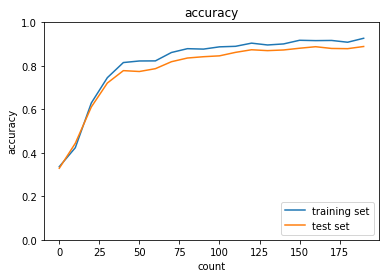

In [5]:
# データの読み込み
(x_train, d_train), (x_test, d_test) = load_mnist(flatten=False)

print("データ読み込み完了")
# 処理に時間のかかる場合はデータを削減 
x_train, d_train = x_train[:5000], d_train[:5000]
x_test, d_test = x_test[:1000], d_test[:1000]


network = DoubleConvNet(input_dim=(1,28,28), 
                          conv_param_1={'filter_num':10, 'filter_size':7, 'pad':1, 'stride':1},
                          conv_param_2={'filter_num':20, 'filter_size':3, 'pad':1, 'stride':1},
                          hidden_size=100, output_size=10, weight_init_std=0.01)

optimizer = optimizer.Adam()

# 時間がかかるため100に設定
iters_num = 200
#iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10



for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]
    
    grad = network.gradient(x_batch, d_batch)
    optimizer.update(network.params, grad)
    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)

    if (i+1) % plot_interval == 0:
        accr_train = network.accuracy(x_train, d_train)
        accr_test = network.accuracy(x_test, d_test)
        accuracies_train.append(accr_train)
        accuracies_test.append(accr_test)
        
        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))               

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()